In [354]:
import re, pandas as pd, numpy as np, chess, chess.engine, matplotlib.pyplot as plt, matplotlib, seaborn as sns
from scipy.stats import norm

In [355]:
%matplotlib inline
sns.set_theme()

### Data Preperation

##### Importing Engine

In [356]:
engine = chess.engine.SimpleEngine.popen_uci(r'C:\Users\Aly\Documents\PythonCourse\Chess\Stockfish14.1\stockfish.exe')

##### Creating ECO Dictionary

ECO stands for the Encyclopedia of Chess Openings. Each opening is give an ECO code consisting of a letter, A-E, that broadly describes the nature of the opening (e.g: Flank Openings, Closed Openings, etc.) followed by a numeric value, 0-99, that provides further detail on the specific system, variations, etc. It will be useful when restricting our analysis to specific opening systems.

In [357]:
# Loading the ECO reference table from a html file
eco_table = pd.read_html('eco_listing.html')[0]

# The regular expressions which will be used to parse and clean the table
primary_exp = '.+?(?=\s1 [A-Za-z]{1,2}\d)'
secondary_exp = '[\w \']+ ?(?=,)?'

# Initializing the regex engines
opening_exp_engine = re.compile(primary_exp)
opening_exp_engine_2 = re.compile(secondary_exp)

# Cleaning up opening table
for i in range(len(eco_table)):
   eco_table.iloc[i,1] = opening_exp_engine_2.match(opening_exp_engine.match(eco_table.iloc[i,1]).group(0)).group(0)

# Assinging key-value pairs to the ECO dictionary.
eco_dict = {}
for i in range(len(eco_table)):
    eco_dict[eco_table.iloc[i,:][0]] = eco_table.iloc[i,:][1]

##### Loading File

In [358]:
with open('Capa-white.pgn') as f:
    games_txt = f.read()

##### Parsing and Cleaning Game Data

Portable Game Notation (PGN) format is organized (broadly speaking) into two sections. First, meta-data  relevant to game is provided (date, site, tournament name, players' mames, ECO code, etc.), followed by the actual list of moves made with possible inclusion of anotations for a move.

In [359]:
# The regular expressions which will be used to parse and clean the PGN text
info_exp = r'((\[.+\]\n){10,})'
games_exp = r'(.+)\n\n\n'
moves_exp = r'[A-Za-z]{0,2}[0-9]?[x+#]?[0-9]?[A-Za-z]\d[\s#+=][A-Za-z]?[\s#+=]?|O-O-O[+#]?\s|O-O[+#]?\s|\d/?2?-\d/?2?'

# Initializing the regex engines
info_engine = re.compile(info_exp)
games_engine = re.compile(games_exp)
moves_engine = re.compile(moves_exp)

# Seperating each game into a single array
games = games_engine.findall(games_txt)

# A list of moves in the list of games. The nth list is the nth game and the nth entry of that list is the nth move played.
games_moves = [[x.strip() for x in moves_engine.findall(y)] for y in games]

# Seperating each game information into an array of strings and formatting it neatly
info = [re.sub(r'[\[\]?.]','',x[0])for x in info_engine.findall(games_txt)]
info = [x.split('\n')[:-1] for x in info]
info[0]

['Event "Havana m"',
 'Site "Havana"',
 'Date "1901"',
 'Round "1"',
 'White "Capablanca, Jose Raul"',
 'Black "Corzo y Prinzipe, Juan"',
 'Result "0-1"',
 'WhiteElo ""',
 'BlackElo ""',
 'ECO "C47"']

##### Extracting Useful Info from Clean Data

Now that we can easily access each game along with its metadata, we proceed to extract the details that will be useful for constructing our Data Frame. We include the following variables:

* Opponent's name
* Result of game
* ECO code
* Opening Name
* Event
* Date
* Tournament Round
* Reference to the game itself

In [360]:
exp = r'"([^"]*)"'

opp = [[x for x in re.findall(exp, info[i][5])][0].strip() for i in range(len(info))] # getting opponents
result_list = [] # getting results
for i in range(len(info)):
    if('1-0' in info[i][6]):
        result_list.append('Win')
        continue
    if('0-1' in info[i][6]):
        result_list.append('Loss')
        continue
    if('1/2-1/2' in info[i][6]):
        result_list.append('Draw')
        continue
    else:
        result_list.append('Undecided')
        
capa_opening_eco = pd.Series([x for x in re.findall(exp, info[i][-1])][0] for i in range(len(info))) # getting ECO code

capa_opening_name = [] # getting name of Eco code
for eco in capa_opening_eco:
    capa_opening_name.append(eco_dict[eco])

capa_events = pd.Series([x for x in re.findall(exp, info[i][0])][0] for i in range(len(info))) # getting events
capa_dates = pd.Series([x for x in re.findall(exp, info[i][2])][0] for i in range(len(info))) # getting events
capa_rounds = pd.Series([[x for x in re.findall(exp, info[i][3])][0] for i in range(len(info))]) # getting rounds
capa_rounds[(capa_rounds=='?')] = '-' # Cleaning rounds data. No round is represented by '-' instead of '?'.

##### Creating a DataFrame

In [361]:
capa_dict = {'ECO': capa_opening_eco, 'Opening': capa_opening_name, 'Opponent': opp, 'Result': result_list, 'Event': capa_events, 'Round': capa_rounds, 'Year': capa_dates, 'Game': games_moves}
capa_df = pd.DataFrame(data=capa_dict) # Creating a DataFrame from above dict

### Insights from the Opening

##### Opening Variations

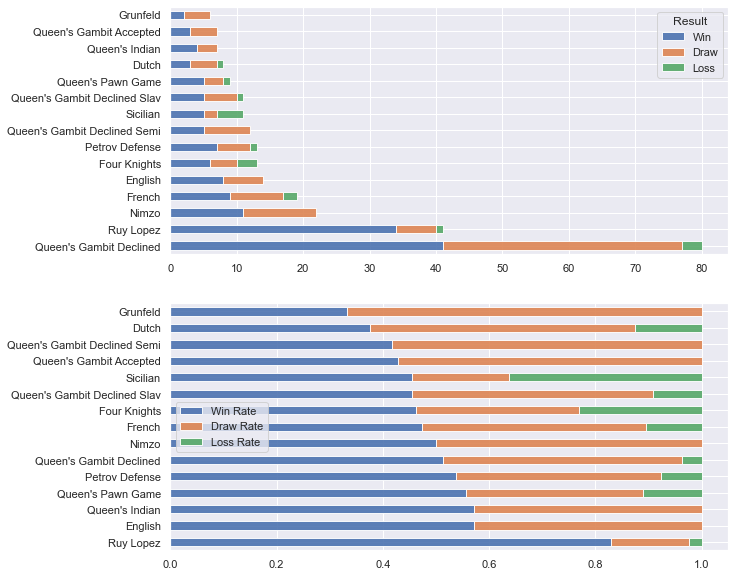

In [731]:
# Top openings
com_open = capa_df.Opening.value_counts()[:15]
open_df = pd.crosstab(index = capa_df.Opening, columns= capa_df.Result).reindex(columns = ('Win','Draw','Loss')).loc[com_open.index]

openr_df = pd.DataFrame([open_df.iloc[:,i].divide(open_df.sum(1)) for i in range(3)]).swapaxes(axis1=0,axis2=1).sort_values(by=[0,1,2],ascending = False)
openr_df.columns = ['Win Rate', 'Draw Rate', 'Loss Rate']

fig, axes = plt.subplots(2, 1, figsize=(10,10))
ax1= open_df.plot.barh(ax=axes[0],stacked = True,alpha=0.9)

ax2= openr_df.plot.barh(ax = axes[1], stacked=True,alpha=0.9)

##### First Move Analysis

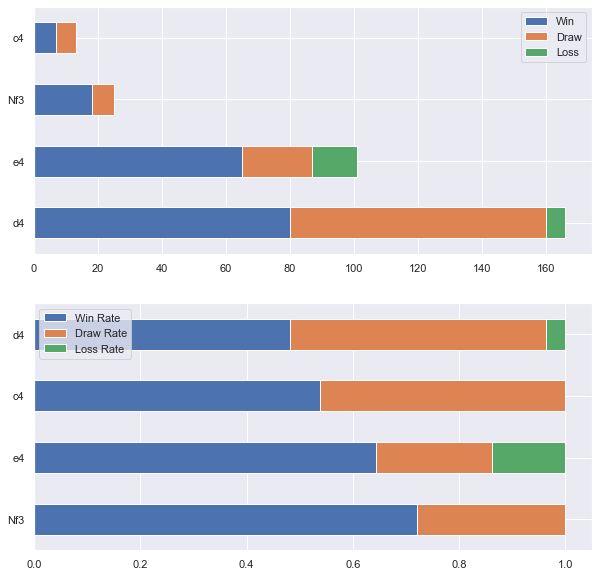

In [363]:
o_moves = pd.Series([x[0] for x in capa_df.Game])
bools = [[(move == x) for x in o_moves] for move in set(o_moves)]
df = pd.DataFrame([capa_df.Result[bools[i]].value_counts() for i in range(6)], index = set(o_moves)).drop('Undecided',axis=1).drop(['f4','e3'],axis=0).fillna(0).sort_values('Win',ascending = False)

dfr = pd.DataFrame([df.iloc[:,i].divide(df.sum(1)) for i in range(3)]).swapaxes(axis1=0,axis2=1).sort_values(by=[0,1,2],ascending = False)
dfr.columns = ['Win Rate', 'Draw Rate', 'Loss Rate']

fig, axes = plt.subplots(2, 1, figsize=(10,10))
ax1= df.plot.barh(ax=axes[0],stacked = True)
ax2 = dfr.plot.barh(ax = axes[1],stacked = True)

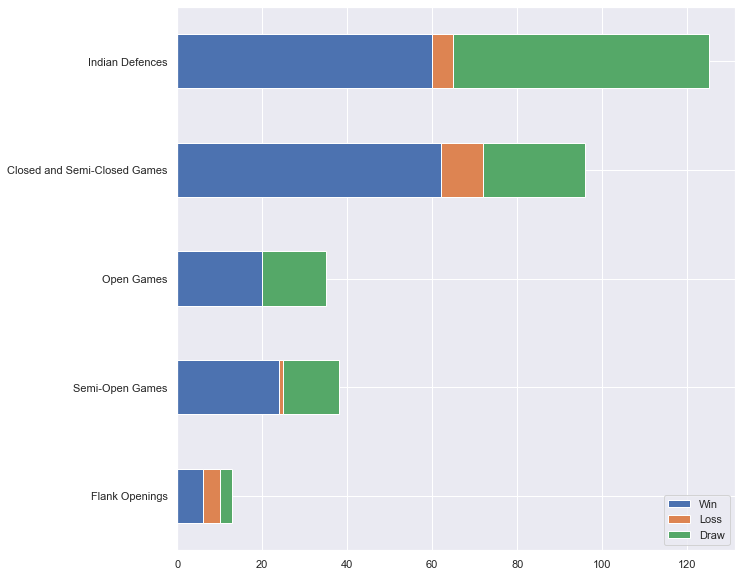

In [364]:
eco_codes = pd.Series([x[0] for x in capa_df.ECO])
bools = [[(move == x) for x in eco_codes] for move in set(eco_codes)]
df = pd.DataFrame([capa_df.Result[bools[i]].value_counts() for i in range(5)], index = ['Flank Openings','Semi-Open Games','Open Games','Closed and Semi-Closed Games','Indian Defences']).drop('Undecided',axis=1).fillna(0)
df
fig, axes = plt.subplots(1, 1, figsize=(10,10))
ax1= df.plot.barh(ax=axes ,stacked = True)

##### Opponents

Text(0.5, 0, 'Number of Games')

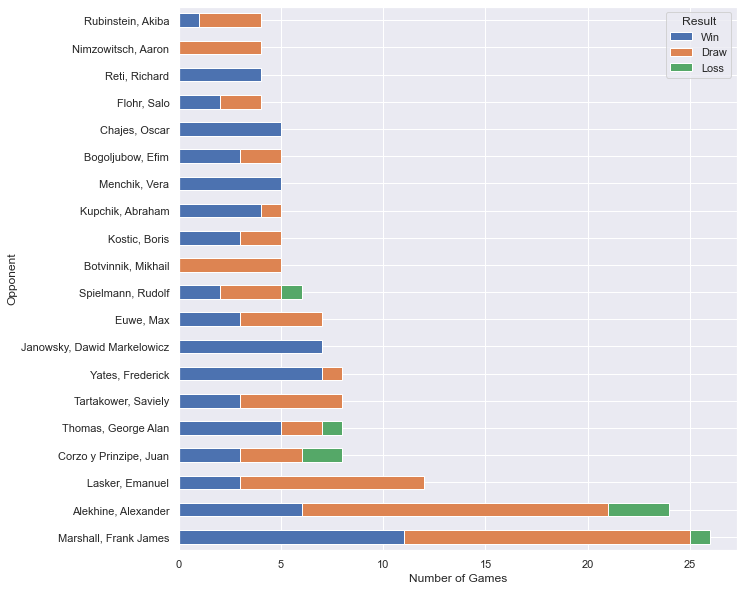

In [365]:
top_opp = list(capa_df.Opponent.value_counts()[:20].index)
opp_df = pd.crosstab(capa_df.Opponent,capa_df.Result).drop('Undecided',axis = 1).loc[top_opp].reindex(columns = ['Win','Draw','Loss'])

fig, axes = plt.subplots(1,1, figsize = (10,10))
ax1 = opp_df.plot.barh(ax = axes,stacked = True)
ax1.set_xlabel('Number of Games')

### Insights from the Middle Game

#### Engine Analysis

In [457]:
analysis = []
analysis_collection = []

for j in range(len(capa_df)):
    board = chess.Board()
    score = 0.3
    for i, move in enumerate(games_moves[j][:-1]):
        board.push_san(move)
        new_score = engine.analyse(board, limit= chess.engine.Limit(depth=10))['score'].white().score(mate_score=10000000000)/100
        if i%2 == 0:
            analysis.append(new_score - score)
        else:
            analysis.append(score - new_score)
        score = new_score
    analysis_collection.append(analysis)
    analysis = []

In [651]:
def remove_outliers(list, lol = False):
    if lol == False:
        return pd.Series([x for x in list if x>-15 and x<15])
    else:
        return pd.Series([x for x in list if (x[1]>-15 and x[1]<15)])

##### Engine Analysis: Capablanca and his rivals

In [522]:
alekhine_idx = list(capa_df[capa_df.Opponent == 'Alekhine, Alexander'].index)
marshall_idx = list(capa_df[capa_df.Opponent == 'Marshall, Frank James'].index)
lasker_idx = list(capa_df[capa_df.Opponent == 'Lasker, Edward'].index)

alekhine_games = [x for i,x in enumerate(analysis_collection) if i in alekhine_idx]
marshall_games = [x for i,x in enumerate(analysis_collection) if i in marshall_idx]
lasker_games = [x for i,x in enumerate(analysis_collection) if i in lasker_idx]

In [523]:
alekhine_data = remove_outliers([x[i] for x in alekhine_games for i in range(len(x)) if i%2 == 1])
capa_alekhine_data = remove_outliers([x[i] for x in alekhine_games for i in range(len(x)) if i%2 == 0])

marshall_data = remove_outliers([x[i] for x in marshall_games for i in range(len(x)) if i%2 == 1])
capa_marshall_data = remove_outliers([x[i] for x in marshall_games for i in range(len(x)) if i%2 == 0])

lasker_data = remove_outliers([x[i] for x in lasker_games for i in range(len(x)) if i%2 == 1])
capa_lasker_data = remove_outliers([x[i] for x in lasker_games for i in range(len(x)) if i%2 == 0])

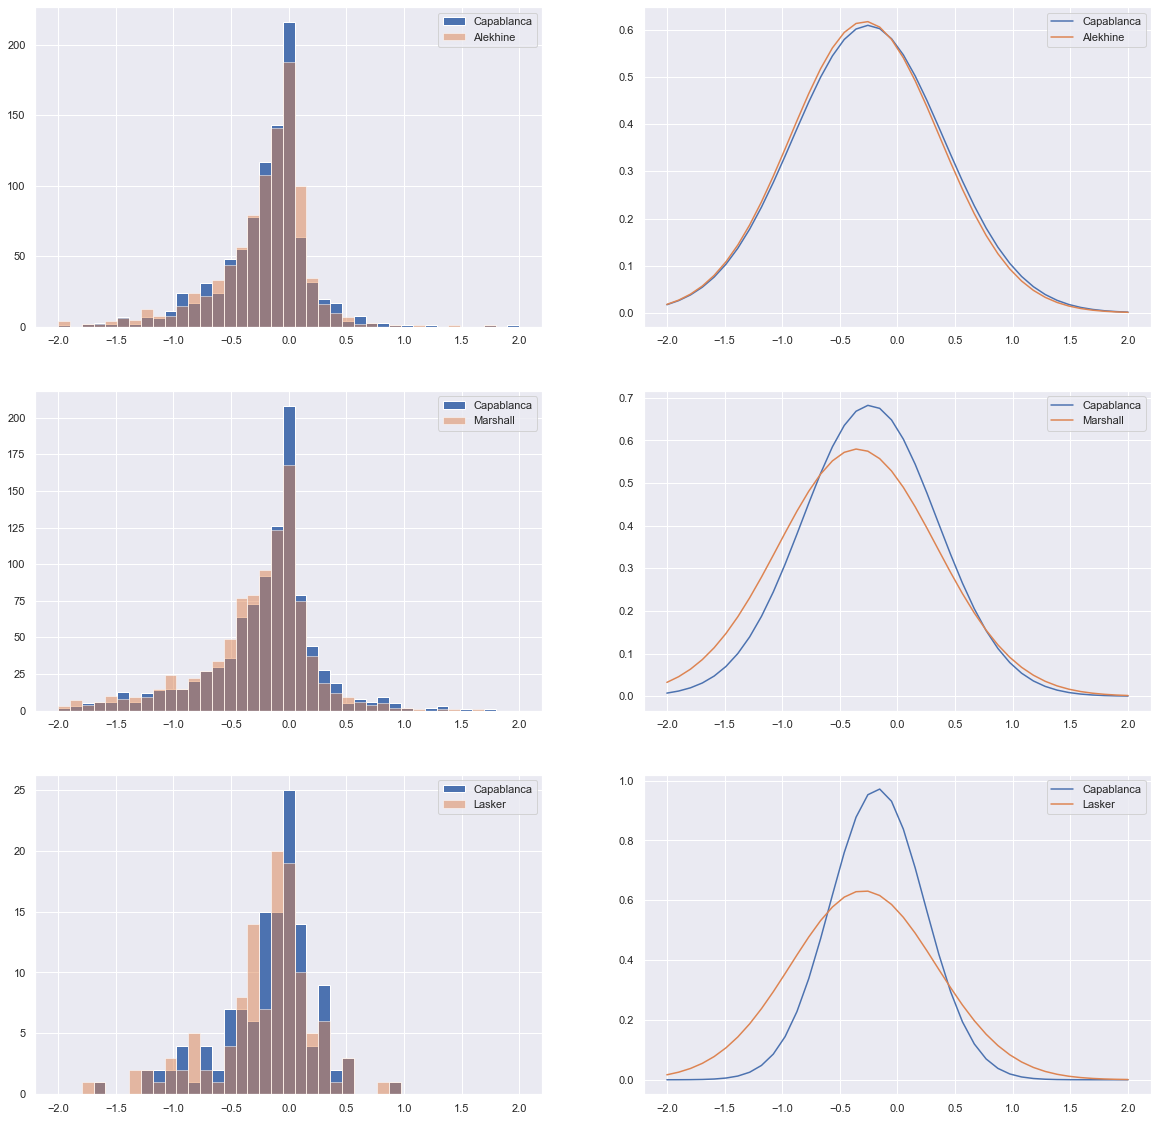

In [525]:
rng = np.linspace(-2,2,40)
fig,axes = plt.subplots(3,2,figsize = (20,20))

p1 = capa_alekhine_data.hist(ax = axes[0][0], bins = rng,label = 'Capablanca')
p2 = alekhine_data.hist(ax = axes[0][0], bins = rng, alpha = 0.5, label = 'Alekhine')
axes[0][1].plot(rng, norm.pdf(rng,loc = capa_alekhine_data.mean(),scale = capa_alekhine_data.std()),label = 'Capablanca')
axes[0][1].plot(rng, norm.pdf(rng,loc = alekhine_data.mean(),scale = alekhine_data.std()),label = 'Alekhine')

p3 = capa_marshall_data.hist(ax = axes[1][0], bins = rng,label = 'Capablanca')
p4 = marshall_data.hist(ax = axes[1][0], bins = rng, alpha = 0.5, label = 'Marshall')
axes[1][1].plot(rng, norm.pdf(rng,loc = capa_marshall_data.mean(),scale = capa_marshall_data.std()),label = 'Capablanca')
axes[1][1].plot(rng, norm.pdf(rng,loc = marshall_data.mean(),scale = marshall_data.std()),label = 'Marshall')

p5 = capa_lasker_data.hist(ax = axes[2][0], bins = rng,label = 'Capablanca')
p6 = lasker_data.hist(ax = axes[2][0], bins = rng, alpha = 0.5,label = 'Lasker')
axes[2][1].plot(rng, norm.pdf(rng,loc = capa_lasker_data.mean(),scale = capa_lasker_data.std()),label = 'Capablanca')
axes[2][1].plot(rng, norm.pdf(rng,loc = lasker_data.mean(),scale = lasker_data.std()),label = 'Lasker')

for i in range(3): 
    for j in range(2): axes[i][j].legend()

##### Engine Analysis: Game Progression

In [751]:
qgd_idx = list(capa_df[capa_df.Opening == "Queen's Gambit Declined"].index)
ruy_idx = list(capa_df[capa_df.Opening == 'Ruy Lopez'].index)
sic_idx = list(capa_df[capa_df.Opening == 'Nimzo'].index)

In [752]:
qgd_moves = remove_outliers([(i,x[i]) for j,x in enumerate(analysis_collection) for i in range(len(x)) if i%2 == 0 and j in qgd_idx], lol=True)
qgd_moves_x = [x[0]/2 for x in qgd_moves]
qgd_moves_y = [x[1] for x in qgd_moves]

ruy_moves = remove_outliers([(i,x[i]) for j,x in enumerate(analysis_collection) for i in range(len(x)) if i%2 == 0 and j in ruy_idx], lol=True)
ruy_moves_x = [x[0]/2 for x in ruy_moves]
ruy_moves_y = [x[1] for x in ruy_moves]

sic_moves = remove_outliers([(i,x[i]) for j,x in enumerate(analysis_collection) for i in range(len(x)) if i%2 == 0 and j in sic_idx], lol=True)
sic_moves_x = [x[0]/2 for x in sic_moves]
sic_moves_y = [x[1] for x in sic_moves]

Text(0.5, 1.0, 'Sicilian')

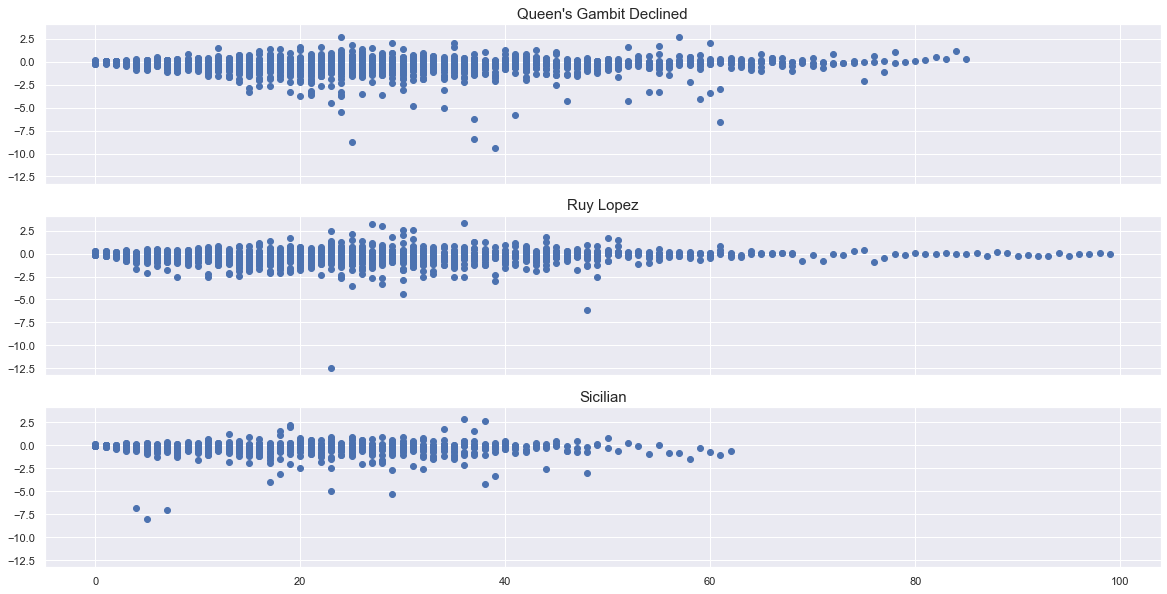

In [754]:
fig,axes = plt.subplots(3,1,figsize=(20,10),sharey=True,sharex=True)

p1 = axes[0].scatter(qgd_moves_x,qgd_moves_y)
axes[0].set_title("Queen's Gambit Declined",size=15)
p2 = axes[1].scatter(ruy_moves_x,ruy_moves_y)
axes[1].set_title('Ruy Lopez',size=15)
p3 = axes[2].scatter(sic_moves_x,sic_moves_y)
axes[2].set_title('Sicilian',size=15)

#### Trading Queens Analysis

In [ ]:
q_track = []

for game in games_moves:
    board = chess.Board()
    i=0
    for move in game[:-1]:
        board.push_san(move)
        i=i+1
        if('Q' not in str(board.board_fen())):
            q_track.append(i/(len(game)-1))
            break
        elif('Q' in str(board.board_fen()) and (i == len(game)-1)):
            q_track.append(1)
q_track = [x*100 for x in q_track]
capa_df['Queen Survival Rate'] = q_track

<AxesSubplot:>

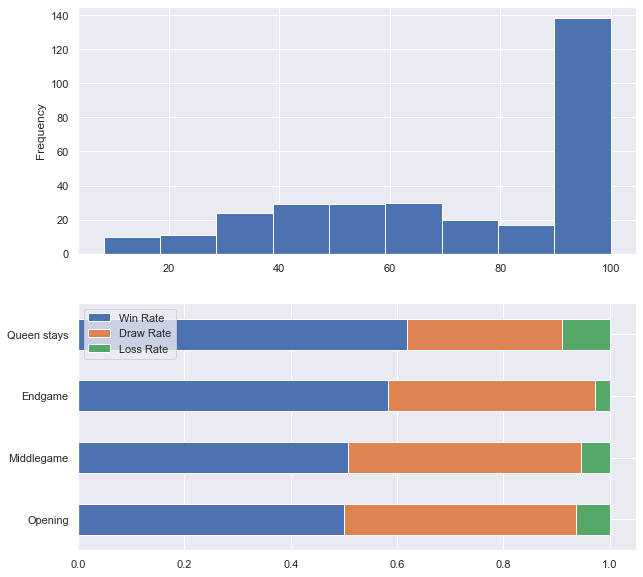

In [ ]:
q=capa_df['Queen Survival Rate']

label = []
for rate in capa_df['Queen Survival Rate']:
    if(rate < (100/4)):
        label.append('Opening')
    elif(rate >= (100/4) and rate <= (75)):
        label.append('Middlegame')
    elif(rate > (75) and rate < (100)):
        label.append('Endgame')
    else:
        label.append('Queen stays')

label_set = ['Opening','Middlegame','Endgame','Queen stays']
capa_df['Queen Survival Label'] = label

w = pd.Series([len(capa_df[(capa_df['Queen Survival Label'] == phase) & (capa_df.Result == 'Win')]) for phase in label_set],index=label_set)
l = pd.Series([len(capa_df[(capa_df['Queen Survival Label'] == phase) & (capa_df.Result == 'Loss')]) for phase in label_set],index=label_set)
d = pd.Series([len(capa_df[(capa_df['Queen Survival Label'] == phase) & (capa_df.Result == 'Draw')]) for phase in label_set],index=label_set)

wr = w.divide(w.add(d.add(l))).sort_values(ascending=True)
dr = d.divide(w.add(d.add(l))).sort_values(ascending=True)
lr = l.divide(w.add(d.add(l))).sort_values(ascending=True)

df = pd.DataFrame({'Win':w, 'Loss':l, 'Draw':d}, index = label_set)
dfr = pd.DataFrame({'Win Rate':wr, 'Draw Rate':dr, 'Loss Rate':lr}, index = label_set).sort_values('Win Rate')

fig, axes = plt.subplots(2, 1, figsize=(10,10))
q.plot.hist(ax = axes[0],bins = 9)
dfr.plot.barh(ax=axes[1], stacked = True)

#### Knights Heatmap

In [160]:
board_maps = [[[0 for i in range(8)] for j in range(8)] for l in range(8)]
numbers = [str(x+1) for x in range(7)]
for o,opening in enumerate(list(com_open.index[:6])):
    for g, game in enumerate(capa_df.Game[capa_df.Opening == opening]):
        board = chess.Board()
        for m,move in enumerate(game[:-1]):
            board.push_san(move)
            if m < len(game)/3 or m> 2*len(game)/3: continue
            pos = board.board_fen()
            rows = pos.split('/')
            for r,row in enumerate(rows):
                c = 0
                for char in row:
                    if(char == '8'):
                        break
                    elif(char in numbers):
                        c = int(char)
                    elif not(char == 'P'):
                        c = c+1
                    elif(char == 'P'):
                        board_maps[o][r][c] = board_maps[o][r][c]+1
                        c = c+1

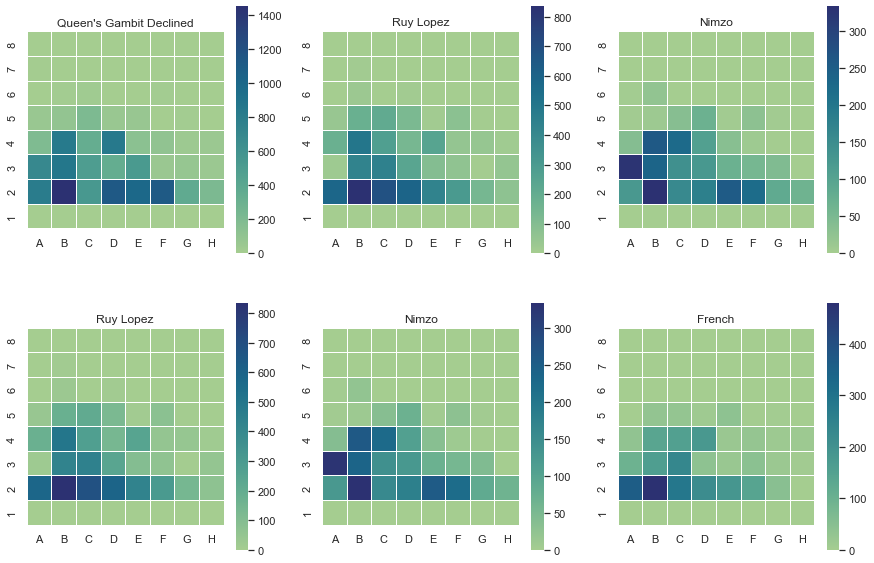

In [161]:
f, axes = plt.subplots(2,3,figsize=(15, 10))
cmap = sns.cm._crest_lut

for i in range(2): 
    for j in range(3):
        sns.heatmap(board_maps[i+j],ax = axes[i][j],xticklabels=['A','B','C','D','E','F','G','H'],cmap = cmap,yticklabels=[8,7,6,5,4,3,2,1],square=True,linewidths=0.5)
        axes[i][j].set_title(list(com_open.index[:6])[i+j])


In [158]:
board_maps = [[[0 for i in range(8)] for j in range(8)] for l in range(8)]
numbers = [str(x+1) for x in range(7)]
for o,opening in enumerate(list(com_open.index[:6])):
    for g, game in enumerate(capa_df.Game[capa_df.Opening == opening]):
        board = chess.Board()
        for m,move in enumerate(game[:-1]):
            board.push_san(move)
            pos = board.board_fen()
            rows = pos.split('/')
            if m < (2*(len(game)/5)) or m > (3*(len(game)/5)):continue
            for r,row in enumerate(rows):
                c = 0
                for char in row:
                    if(char == '8'):
                        break
                    elif(char in numbers):
                        c = int(char)
                    elif not(char == 'N'):
                        c = c+1
                    elif(char == 'N'):
                        board_maps[o][r][c] = board_maps[o][r][c]+1
                        c = c+1

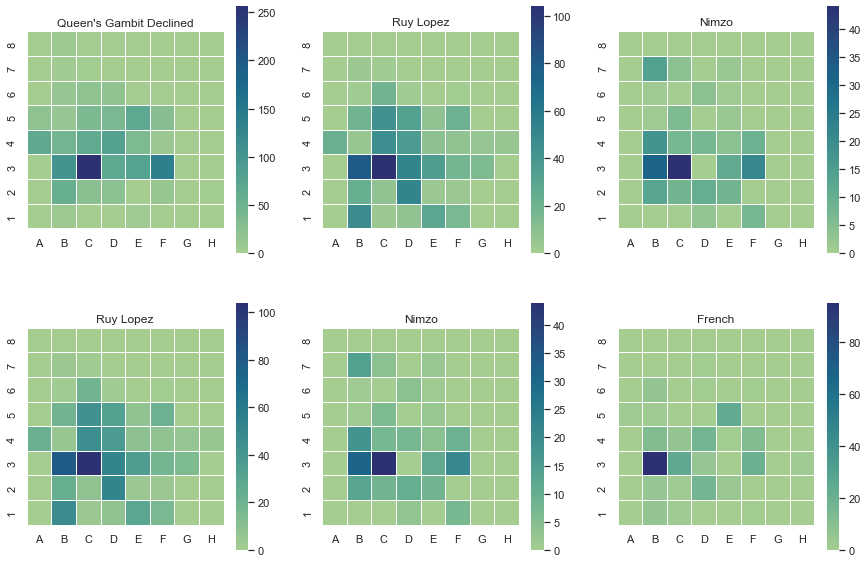

In [159]:
f, axes = plt.subplots(2,3,figsize=(15, 10))
cmap = sns.cm._crest_lut

for i in range(2): 
    for j in range(3):
        sns.heatmap(board_maps[i+j],ax = axes[i][j],xticklabels=['A','B','C','D','E','F','G','H'],cmap = cmap,yticklabels=[8,7,6,5,4,3,2,1],square=True,linewidths=0.5)
        axes[i][j].set_title(list(com_open.index[:6])[i+j])


In [136]:
list(com_open.index[:4])[0]

"Queen's Gambit Declined"